In [6]:
import cv2
import os, os.path
from random import *
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import math
from pylab import *
from numpy.linalg import inv
from sklearn.metrics import roc_curve

In [9]:
def path(n):

    if n == 1:
        imageDir_face = "./Dataset/train_face"
    elif n==2:
        imageDir_face = "./Dataset/train_non"
    elif n==3:
        imageDir_face = "./Dataset/test_face"
    else:
        imageDir_face = "./Dataset/test_non"

    #imageDir_face = "train_face" #specify your path here
    image_path_list_face = []
    valid_image_extensions = [".jpg"] #specify your vald extensions here
    valid_image_extensions = [item.lower() for item in valid_image_extensions]

    image_list_face = []

    for root, dirs, files in os.walk(imageDir_face):
        for file in files:
            with open(os.path.join(root, file), "r") as auto:
                extension = os.path.splitext(file)[1]
                if extension.lower() not in valid_image_extensions:
                    continue
                image_list_face.append(os.path.join(root, file))

    flattened_space_face = []
    for imagePath in image_list_face:
        image = cv2.imread(imagePath)
        image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        flattened = image_gray.flatten()
        flattened_space_face.append(flattened)
    return flattened_space_face

# #############################################################################
# #############################################################################

def Initial_parameters(flattened_space_face, k):

    Mean = np.mean(flattened_space_face, axis=0)
    Cov = np.diag(np.diag(np.cov(np.transpose(flattened_space_face))))
    phi = np.random.random_sample((100, k))

    return Mean, Cov, phi

# #############################################################################
# #############################################################################

def Estep( k, flattened_space_face, phi, Mean, Cov):

    expectation_h = np.zeros((k, len(flattened_space_face)))
    expectation_h_ht = np.zeros((k,k, len(flattened_space_face)))
    a = np.zeros((k,k,len( flattened_space_face)))

    for i in range(len(flattened_space_face)):
        temp1 = np.matmul(phi.transpose(),inv(Cov))
        temp2 = np.matmul(temp1,phi) + np.eye(k)
        temp3 = np.matmul(np.matmul(inv(temp2),phi.transpose()), inv(Cov))
        expectation_h[:,i] = np.matmul(temp3, ((flattened_space_face[i]- Mean).transpose()))
        a[:,:,i] = expectation_h[:,i]*(expectation_h[:,i][np.newaxis]).transpose()
        expectation_h_ht[:,:,i] = inv(temp2) + a[:,:,i]

    return expectation_h, expectation_h_ht

# #############################################################################
# #############################################################################

def Mstep(k,expectation_h, expectation_h_ht,Mean, flattened_space_face ):

    sum_expectation = np.sum(expectation_h_ht, axis=2)

    y = np.zeros((100,k,len(flattened_space_face)))
    for i in range(len(flattened_space_face)):
        y[:,:,i] = np.matmul((flattened_space_face[i]-Mean)[np.newaxis].transpose(), (expectation_h[:,i][np.newaxis]))

    new_phi = np.matmul((np.sum(y,axis=2)),inv(sum_expectation))

    z = np.zeros((100,100,len(flattened_space_face)))
    for i in range(len(flattened_space_face)):
        b = (flattened_space_face[i]-Mean)[np.newaxis]
        z_temp = np.matmul(new_phi, expectation_h[:,i])
        z_temp2 = np.matmul(z_temp[np.newaxis].transpose(),b)
        z[:,:,i] = b*b.transpose()-z_temp2

    Cov_temp = np.sum(z,axis=2)
    new_Cov = Cov_temp/(len(flattened_space_face))

    phi = new_phi
    Cov = new_Cov+(1000*np.eye(100))

    return phi, Cov

# #############################################################################
# #############################################################################


def Norm(flattened_space_test, Cov, Mean):

    Cov_total = np.matmul(phi,phi.transpose()) + Cov
    pdf = np.zeros(len(flattened_space_test))
    log_pdf = np.zeros(len(flattened_space_test))
    for i in range(len(flattened_space_test)):
        d = np.matmul((flattened_space_test[i] - Mean),(inv(Cov_total)))
        #print d_face
        d1 = np.matmul(d,((flattened_space_test[i] - Mean).transpose()))
        #print d1_face
        pdf[i] = np.exp(-0.5*d1)
#        log_pdf[i] = np.log(pdf)
        #print log_pdf
    return pdf

def Posterior(test_face, test_non):
    Posterior_face = test_face/(test_face + test_non)
    Posterior_non = test_non/(test_face + test_non)
    return Posterior_face, Posterior_non
# ################################################

initial phi [[0.46975657 0.08283582 0.13142921 0.89089569 0.25091704]
 [0.05515693 0.12010634 0.08287057 0.81908298 0.40148657]
 [0.86151388 0.98881837 0.42437371 0.63053114 0.36715128]
 [0.05873466 0.72141967 0.33572558 0.98344725 0.47999728]
 [0.66017317 0.21276883 0.16422714 0.83685114 0.03805053]
 [0.08246222 0.14226549 0.23957161 0.20314941 0.13598944]
 [0.26301917 0.9313844  0.16709862 0.84952595 0.81212406]
 [0.42584158 0.36425872 0.14274877 0.07380227 0.84556662]
 [0.1570629  0.24833758 0.52295296 0.09549474 0.48474061]
 [0.44255065 0.42892056 0.31805812 0.10504103 0.45083957]
 [0.31595873 0.58742623 0.05787036 0.08129841 0.04276695]
 [0.1351746  0.80775513 0.02281728 0.42582264 0.63891856]
 [0.07208591 0.98458725 0.47971256 0.84131314 0.19309348]
 [0.50429342 0.16736892 0.95286721 0.21199605 0.75015737]
 [0.54888574 0.43156375 0.0904651  0.23116869 0.3992357 ]
 [0.73550319 0.30765058 0.87927323 0.66231958 0.5234554 ]
 [0.40985529 0.34427593 0.4191185  0.85669966 0.55946194]
 [

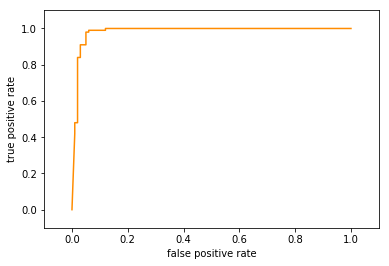

In [11]:
iteration = 20
k=5

flattened_space_face = path(1)
flattened_space_non = path(2)
flattened_space_test_face = path(3)
flattened_space_test_non = path(4)


Mean, Cov, phi = Initial_parameters(flattened_space_face, k)
Mean_non, Cov_non, phi_non = Initial_parameters(flattened_space_non, k)

print("initial phi", phi)

for iter in range(iteration):
    if iter < iteration:
        print("iter: ", iter)
        expectation_h, expectation_h_ht = Estep( k, flattened_space_face, phi, Mean, Cov)
        phi, Cov = Mstep(k,expectation_h, expectation_h_ht,Mean, flattened_space_face )

        expectation_h_non, expectation_h_ht_non = Estep( k, flattened_space_non, phi, Mean, Cov)
        phi_non, Cov_non = Mstep(k,expectation_h_non, expectation_h_ht_non,Mean_non, flattened_space_non )


log_pdf_Testface_wrt_face =  Norm(flattened_space_test_face, Cov, Mean)
log_pdf_Testface_wrt_non =  Norm(flattened_space_test_face, Cov_non, Mean_non)

log_pdf_Testnon_wrt_face =  Norm(flattened_space_test_non, Cov, Mean)
log_pdf_Testnon_wrt_non =  Norm(flattened_space_test_non, Cov_non, Mean_non)


# #############################################################################


Mean_show=np.reshape(Mean,(10,10))
cv2.imwrite('Mean_FA_face.jpg',Mean_show)

Mean_show_non=np.reshape(Mean_non,(10,10))
cv2.imwrite('Mean_FA_non.jpg',Mean_show_non)

cv2.imwrite('Cov_FA_face.jpg',Cov)

cv2.imwrite('Cov_FA_non.jpg',Cov_non)

Posterior_testface_face, Posterior_testface_non  = Posterior(log_pdf_Testface_wrt_face, log_pdf_Testface_wrt_non)
Posterior_testnon_face, Posterior_testnon_non  = Posterior(log_pdf_Testnon_wrt_face, log_pdf_Testnon_wrt_non)

count = 0
for i in range(len(Posterior_testface_face)):
    if Posterior_testface_face[i]> Posterior_testface_non[i]:
        count=count+1
print("count of positively classified faces: ", count)


count1 = 0
for i in range(len(Posterior_testface_face)):
    if Posterior_testnon_non[i]> Posterior_testnon_face[i]:
        count1=count1+1
print("count of positively classified non-faces: ", count1)


count_false_positive = 0
for i in range(len(Posterior_testface_face)):
    if Posterior_testnon_face[i]> 0.5:
        count_false_positive=count_false_positive+1
print("False Positive Rate ", float(count_false_positive)/100)


count_false_negative = 0
for i in range(len(Posterior_testface_face)):
    if Posterior_testface_non[i]> 0.5:
        count_false_negative = count_false_negative + 1
print("False Negative Rate ", float(count_false_negative)/100)

misclassification = (float(count_false_positive + count_false_negative)) / (len(Posterior_testface_face) + len(Posterior_testface_face))
print("Misclassification Rate", misclassification)


Posterior = np.append(   Posterior_testface_face, (Posterior_testnon_face))
labels = np.append(np.ones(100), np.zeros(100)   )

# ##############################################################################
# PLot ROC Curve

fpr, tpr, _ = roc_curve(labels, Posterior, pos_label=1)
plt.plot(fpr, tpr, color='darkorange')
plt.xlabel("false positive rate")
plt.ylabel("true positive rate" )
plt.xlim([-0.1,1.1])
plt.ylim([-0.1,1.1])
plt.show()